# 3: Classification
This follows the third chapter named **Classification** in the book **Hands-on Machine Learning with Scikit-Learn, Keras, and Tensorflow**

#### Modules needed for this Project

In [37]:
# Data Preprocessing
import numpy as np
import pandas as pd

# Visulaization Tools
import matplotlib as ml
import matplotlib.pyplot as plt

# Machine Learning Modules
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator

# 3.1 MNIST

In this chapter we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. 

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset:

In [3]:
# from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure, including the following:
* A <b>DESCR</b> key describing the dataset
* A <b>data</b> key containing a two dimensioanl array with one row per instance and one column per feature:
  * one row = 1 image (total 70000 images)
  * one column in a row: one feature of the picture
* A <b>target</b> key containing an array with the labels

Let’s look at these arrays:

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

Let’s take a peek at one digit from the dataset. All you need to do is **grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it using Matplotlib’s *imshow()* function:**

In [14]:
X.head(1)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


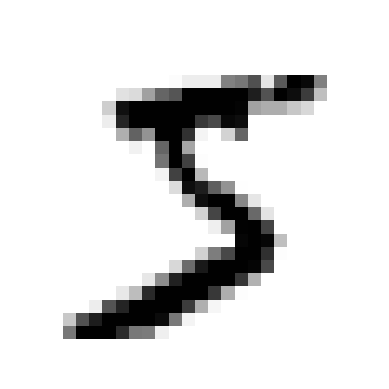

In [22]:
# import matplotlib as ml
# import matplotlib.pyplot as plt

# some_digit = X[0] is the book version.But it doesn't work,
# becuase X is not an array, but a DataFrame

some_digit = X.iloc[0].to_numpy()
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show();

In [23]:
# The above picture looks like a '5'. But just to be sure:
y[0]

'5'

Note that the label is a string. Most ML algorithms expect numbers, so let’s cast y to integer:

In [24]:
y = y.astype(np.uint8)

You should always create a test set and set it aside before inspecting the data closely. The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [25]:
X_train, y_train = X[:60000], y[:60000]
X_test, y_test = X[60000:], y[60000:]

The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar (you don’t want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen.

# 3.2: Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a **binary classifier**, capable of distinguishing between just two classes, 5 and not-5. 

Let’s create the target vectors for this classification task:

In [27]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Now let’s pick a classifier and train it. A good place to start is with a Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn’s ***SGDClassifier*** class. This classifier has the advantage of being capable of handling very large datasets efficiently.

In [29]:
# from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [30]:
# Now we can use it to detect images of the number 5
sgd_clf.predict([some_digit])

C:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

The classifier guesses this image represents a True means 5.

# 3.3: Performance Measures

When it comes to evaluating a classifier there are many methos.

## 3.3.1: Measuring Accuracy Using Cross-Validation
A good way to evaluate a model by cross-validation.

Let’s use the cross_val_score() function to evaluate our SGDClassifier model,
using K-fold cross-validation with three folds. Remember that K-fold cross-validation means splitting the training set into K folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds.

In [36]:
# from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Above 93% accuracy (ratio of correct predictions) on all cross-validation folds. Before you get too excited, let’s look at a very dumb classifier that just classifies every single image in the “not-5” class:

In [40]:
# from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [41]:
# Lets see this models accuracy
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Even this model has over 90% accuracy. This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. 

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

## 3.3.2: Confusion Matrix
